In [6]:
import csv
import requests
import pandas as pd
import numpy as np
import io
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Datasets

In [7]:
df_penetracion = pd.read_csv('../data/processed/penetracion.csv')
df_penetracion_provincia = pd.read_csv('../data/processed/penetracion_provincia.csv')
df_internet_ingresos = pd.read_csv('../data/processed/internet_ingresos.csv')

In [8]:
# Ordena los datos por provincia y cuatrimestre
df_penetracion_provincia.sort_values(by=['Provincia', 'Año', 'Trimestre'], inplace=True)

# Calcula la tasa de crecimiento de un cuatrimestre a otro para cada provincia
df_penetracion_provincia['Tasa de Crecimiento Penetracion'] = df_penetracion_provincia.groupby('Provincia')['Accesos por cada 100 hogares'].pct_change(periods=4) * 100

# Reemplaza los valores nulos por 0 en la columna 'Tasa de Crecimiento'
df_penetracion_provincia['Tasa de Crecimiento Penetracion'] = df_penetracion_provincia['Tasa de Crecimiento Penetracion'].fillna(0)

# Muestra el DataFrame con la tasa de crecimiento calculada
df_penetracion_provincia.head(1)

,Año,Trimestre,Provincia,Accesos por cada 100 hogares,Tasa de Crecimiento Penetracion
840,2014,1,Buenos Aires,54.57,0.0


In [9]:
# df_penetracion_ingresos
# Crea una nueva columna 'Año_Trimestre' en ambos DataFrames
df_penetracion_provincia['Año_Trimestre'] = df_penetracion_provincia['Año'].astype(str) + '_' + df_penetracion_provincia['Trimestre'].astype(str)
df_internet_ingresos['Año_Trimestre'] = df_internet_ingresos['Año'].astype(str) + '_' + df_internet_ingresos['Trimestre'].astype(str)

# Dropear las columnas 'Año' y 'Trimestre' en ambos DataFrames
df_penetracion_provincia_clean = df_penetracion_provincia.drop(columns=['Año', 'Trimestre'])
df_internet_ingresos_clean = df_internet_ingresos.drop(columns=['Año', 'Trimestre', 'Periodo'])

# Realiza el merge en base a la columna 'Año_Trimestre'
df_penetracion_ingresos = pd.merge(df_penetracion_provincia_clean, df_internet_ingresos_clean, on='Año_Trimestre')

# Recupera las columnas 'Año' y 'Trimestre' a partir de 'Año_Trimestre' y luego dropea 'Año_Trimestre'
df_penetracion_ingresos[['Año', 'Trimestre']] = df_penetracion_ingresos['Año_Trimestre'].str.split('_', expand=True)
df_penetracion_ingresos = df_penetracion_ingresos.drop(columns=['Año_Trimestre'])

# Diccionario con tasas de cambio de pesos a dólares (dólar blue)
tasas_de_cambio = {
    2022: 0.007846,
    2021: 0.01054,
    2020: 0.01445,
    2019: 0.02144,
    2018: 0.03759,
    2017: 0.06058,
    2016: 0.06787,
    2015: 0.1090,
    2014: 0.1235
}

# Agregar una nueva columna "Ingresos (miles USD)" al DataFrame
df_penetracion_ingresos['Ingresos (miles USD)'] = df_penetracion_ingresos.apply(
    lambda row: round(row['Ingresos (miles de pesos)'] * tasas_de_cambio[int(row['Año'])]/1000,2), axis=1
)

# Calcula la tasa de crecimiento de ingresos en miles de USD por año
df_penetracion_ingresos['Tasa de Crecimiento Ingresos'] = df_penetracion_ingresos.groupby('Provincia')['Ingresos (miles USD)'].pct_change(periods=4) * 100

# Reemplaza los valores nulos por 0 en la columna 'Tasa de Crecimiento'
df_penetracion_ingresos['Tasa de Crecimiento Ingresos'] = df_penetracion_ingresos['Tasa de Crecimiento Ingresos'].fillna(0)

# Combina las columnas de año y trimestre en una nueva columna llamada "Año-Trimestre"
df_penetracion_ingresos['Año-Trimestre'] = df_penetracion_ingresos['Año'].astype(str) + '-' + df_penetracion_ingresos['Trimestre'].astype(str)

# Muestra las primeras filas del DataFrame actualizado
df_penetracion_ingresos.tail(1)

,Provincia,Accesos por cada 100 hogares,Tasa de Crecimiento Penetracion,Ingresos (miles de pesos),Año,Trimestre,Ingresos (miles USD),Tasa de Crecimiento Ingresos,Año-Trimestre
863,Tucumán,61.04,9.136421,72443482.99,2022,4,568.39,18.604845,2022-4


In [10]:
df_tecnologia_provincia = pd.read_csv('../data/processed/internet_accesos_tecnologia.csv')
df_internet_historico = pd.read_csv('../data/processed/internet_historico.csv')

In [11]:
# Crea una nueva columna 'Año_Trimestre' en ambos DataFrames
df_tecnologia_provincia['Año-Trimestre-Provincia'] = df_tecnologia_provincia['Año'].astype(str) + '_' + df_tecnologia_provincia['Trimestre'].astype(str) + '_' + df_tecnologia_provincia['Provincia']
df_internet_historico['Año-Trimestre-Provincia'] = df_internet_historico['Año'].astype(str) + '_' + df_internet_historico['Trimestre'].astype(str) + '_' + df_internet_historico['Provincia']

# Dropear las columnas 'Año', 'Trimestre' y 'Provincia' en ambos DataFrames
df_tecnologia_provincia_clean = df_tecnologia_provincia.drop(columns=['Año', 'Trimestre', 'Provincia'])
df_internet_historico_clean = df_internet_historico.drop(columns=['Año', 'Trimestre', 'Provincia'])

# Realiza el merge en base a la columna 'Año_Trimestre'
df_tecnologia_velocidad = pd.merge(df_tecnologia_provincia_clean, df_internet_historico_clean, on='Año-Trimestre-Provincia')

# Recupera las columnas 'Año', 'Trimestre' y 'Provincia' a partir de 'Año_Trimestre' y luego dropea 'Año_Trimestre'
df_tecnologia_velocidad[['Año', 'Trimestre', 'Provincia']] = df_tecnologia_velocidad['Año-Trimestre-Provincia'].str.split('_', expand=True)
df_tecnologia_velocidad = df_tecnologia_velocidad.drop(columns=['Año-Trimestre-Provincia'])

# Reorganiza el orden de las columnas
column_order = ['Provincia', 'Año', 'Trimestre', 'ADSL', 'Cablemodem', 'Fibra óptica', 'Wireless', 'Otros', 'Total', 'Mbps (Media de bajada)', 'Tasa de Crecimiento']
df_tecnologia_velocidad = df_tecnologia_velocidad[column_order]

# Cambiar el tipo de dato de la columna
df_tecnologia_velocidad = df_tecnologia_velocidad.astype({'Año': 'int64', 'Trimestre': 'int64'})
df_tecnologia_velocidad['Año'] = df_tecnologia_velocidad['Año'].astype(int)

# Dropear la columna 'Otros' y recalcular 'Total'
df_tecnologia_velocidad.drop(columns=['Otros'], inplace=True)
df_tecnologia_velocidad['Total'] = df_tecnologia_velocidad['ADSL'] + df_tecnologia_velocidad['Cablemodem'] + df_tecnologia_velocidad['Fibra óptica'] + df_tecnologia_velocidad['Wireless']

# Muestra las primeras filas del DataFrame fusionado para verificar
df_tecnologia_velocidad.head(10)

,Provincia,Año,Trimestre,ADSL,Cablemodem,Fibra óptica,Wireless,Total,Mbps (Media de bajada),Tasa de Crecimiento
0,Buenos Aires,2022,4,325908,2767247,1499149,129910,4722214,111.00,1.58
1,Capital Federal,2022,4,138753,1238196,138548,4603,1520100,182.90,1.81
2,Catamarca,2022,4,8952,10998,47337,1379,68666,83.30,1.37
3,Chaco,2022,4,24582,61265,47285,7957,141089,104.00,1.95
4,Chubut,2022,4,45450,73923,9815,30721,159909,15.92,1.02
5,Córdoba,2022,4,152265,456947,367393,61631,1038236,108.75,1.93
6,Corrientes,2022,4,34038,80283,26752,9082,150155,94.75,2.10
7,Entre Ríos,2022,4,55507,135746,40798,26414,258465,87.50,2.06
8,Formosa,2022,4,13735,17068,13118,17692,61613,72.00,2.37
9,Jujuy,2022,4,17880,52390,42626,4067,116963,39.30,1.21


In [4]:
df = pd.read_csv('../data/processed/kpi.csv')
df.head(1)

,Provincia,Año,Trimestre,ADSL,Cablemodem,Fibra optica,Wireless,Total Tecnologia,Mbps (Media de bajada),Tasa de crecimiento Velocidad,Accesos por cada 100 hogares,Tasa de Crecimiento Penetracion,Ingresos (miles de pesos),Ingresos (miles USD),Tasa de Crecimiento Ingresos
0,Buenos Aires,2022,4,6.901593,58.600627,31.74674,2.75104,4722214,111.0,1.58,78.94,4.335184,72443482.99,568.39,18.604845


# Análisis

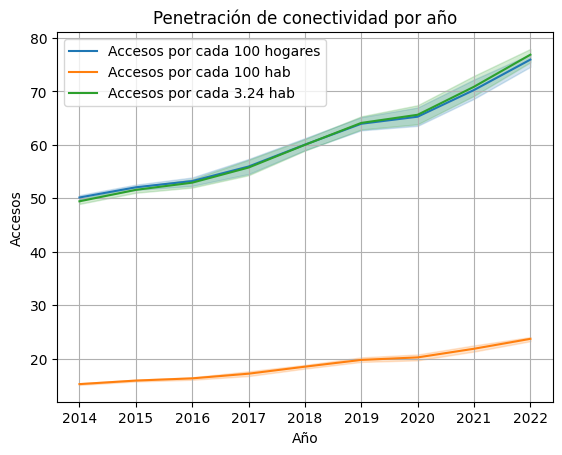

In [12]:
# Gráfico de línea para 'Accesos por cada 100 hogares'
sns.lineplot(data=df_penetracion, x='Año', y='Accesos por cada 100 hogares', label='Accesos por cada 100 hogares')

# Gráfico de línea para 'Accesos por cada 100 hab'
sns.lineplot(data=df_penetracion, x='Año', y='Accesos por cada 100 hab', label='Accesos por cada 100 hab')

# Calcular 'Accesos por cada 3.24 hab'
df_penetracion['Accesos por cada 3.24 hab'] = df_penetracion['Accesos por cada 100 hab'] * 3.24

# Gráfico de línea para 'Accesos por cada 3.24 hab'
sns.lineplot(data=df_penetracion, x='Año', y='Accesos por cada 3.24 hab', label='Accesos por cada 3.24 hab')

plt.xlabel('Año')
plt.ylabel('Accesos')
plt.title('Penetración de conectividad por año')
plt.grid()
plt.legend()
plt.show()
